# Project for CS545

Sam Armstrong, Saloni Choudhary, Brandon Hua

In [90]:
import pandas as pd
import datetime
# univariate stacked lstm example
# from numpy import array
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

## Get Data


In [91]:
# Run these pip3 installs once to install yahoo finance libraries
# !pip3 install yahoo-finance --user
# !pip3 install yfinance --user --upgrade --no-cache-dir

import yfinance as yf
# Documentation at https://pypi.org/project/yfinance/

In [92]:
tickers = 'mmm axp aapl ba cat cvx csco ko dis xom ge gs hd ibm intc jnj jpm mcd mrk msft nke pfe pg trv utx unh vz v wmt'
# exclude dwdp because it's historical data only goes back 1 year
period = '5y'

data = yf.download(tickers, period=period)
data.columns = ['%s%s' % (a, ' %s' % b if b else '') for a, b in data.columns]
data[data.isna().any(axis=1)] #Display rows with Null values

[*********************100%***********************]  29 of 29 completed


,Adj Close AAPL,Adj Close AXP,Adj Close BA,Adj Close CAT,Adj Close CSCO,Adj Close CVX,Adj Close DIS,Adj Close GE,Adj Close GS,Adj Close HD,...,Volume NKE,Volume PFE,Volume PG,Volume TRV,Volume UNH,Volume UTX,Volume V,Volume VZ,Volume WMT,Volume XOM
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
data = data.drop([datetime.datetime(2016, 1, 18)])
data.shape

(1259, 174)

## Data

The data comprises of 29 stocks [mmm axp aapl ba cat cvx csco ko dis xom ge gs hd ibm intc jnj jpm mcd mrk msft nke pfe pg trv utx unh vz v wmt] over a 5 year period (end date is current date) with 252 days in a year (except 2016 whichis missing the date 2016-01-18). Each date entry has 6 variables [Adjusted Close, Close, High, Low, Open, Volume]. We are trying to predict the next day's Close. 

In [94]:
MMM = data[['Adj Close MMM', 'Close MMM', 'High MMM', 'Low MMM', 'Open MMM', 'Volume MMM']]
MMM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
AAPL = data[['Adj Close AAPL', 'Close AAPL', 'High AAPL', 'Low AAPL', 'Open AAPL', 'Volume AAPL']]
AAPL.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
AXP = data[['Adj Close AXP', 'Close AXP', 'High AXP', 'Low AXP', 'Open AXP', 'Volume AXP']]
AXP.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
BA = data[['Adj Close BA', 'Close BA', 'High BA', 'Low BA', 'Open BA', 'Volume BA']]
BA.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
CAT = data[['Adj Close CAT', 'Close CAT', 'High CAT', 'Low CAT', 'Open CAT', 'Volume CAT']]
CAT.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
CVX = data[['Adj Close CVX', 'Close CVX', 'High CVX', 'Low CVX', 'Open CVX', 'Volume CVX']]
CVX.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
CSCO = data[['Adj Close CSCO', 'Close CSCO', 'High CSCO', 'Low CSCO', 'Open CSCO', 'Volume CSCO']]
CSCO.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
KO = data[['Adj Close KO', 'Close KO', 'High KO', 'Low KO', 'Open KO', 'Volume KO']]
KO.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
DIS = data[['Adj Close DIS', 'Close DIS', 'High DIS', 'Low DIS', 'Open DIS', 'Volume DIS']]
DIS.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
XOM = data[['Adj Close XOM', 'Close XOM', 'High XOM', 'Low XOM', 'Open XOM', 'Volume XOM']]
XOM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
GE = data[['Adj Close GE', 'Close GE', 'High GE', 'Low GE', 'Open GE', 'Volume GE']]
GE.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
GS = data[['Adj Close GS', 'Close GS', 'High GS', 'Low GS', 'Open GS', 'Volume GS']]
GS.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
HD = data[['Adj Close HD', 'Close HD', 'High HD', 'Low HD', 'Open HD', 'Volume HD']]
HD.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
IBM = data[['Adj Close IBM', 'Close IBM', 'High AAPL', 'Low IBM', 'Open IBM', 'Volume IBM']]
IBM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
INTC = data[['Adj Close INTC', 'Close INTC', 'High INTC', 'Low INTC', 'Open INTC', 'Volume INTC']]
INTC.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
JNJ = data[['Adj Close JNJ', 'Close JNJ', 'High JNJ', 'Low JNJ', 'Open JNJ', 'Volume JNJ']]
JNJ.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
JPM = data[['Adj Close JPM', 'Close JPM', 'High JPM', 'Low JPM', 'Open JPM', 'Volume JPM']]
JPM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
MCD = data[['Adj Close MCD', 'Close MCD', 'High MCD', 'Low MCD', 'Open MCD', 'Volume MCD']]
MCD.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
MRK = data[['Adj Close MRK', 'Close MRK', 'High MRK', 'Low MRK', 'Open MRK', 'Volume MRK']]
MRK.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
MSFT = data[['Adj Close MSFT', 'Close MSFT', 'High MSFT', 'Low MSFT', 'Open MSFT', 'Volume MSFT']]
MSFT.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
NKE = data[['Adj Close NKE', 'Close NKE', 'High NKE', 'Low NKE', 'Open NKE', 'Volume NKE']]
NKE.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
PFE = data[['Adj Close PFE', 'Close PFE', 'High PFE', 'Low PFE', 'Open PFE', 'Volume PFE']]
PFE.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
PG = data[['Adj Close PG', 'Close PG', 'High PG', 'Low PG', 'Open PG', 'Volume PG']]
PG.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
TRV = data[['Adj Close TRV', 'Close TRV', 'High TRV', 'Low TRV', 'Open TRV', 'Volume TRV']]
TRV.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
UTX = data[['Adj Close UTX', 'Close UTX', 'High UTX', 'Low UTX', 'Open UTX', 'Volume UTX']]
UTX.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
UNH = data[['Adj Close UNH', 'Close UNH', 'High UNH', 'Low UNH', 'Open UNH', 'Volume UNH']]
UNH.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
VZ = data[['Adj Close VZ', 'Close VZ', 'High VZ', 'Low VZ', 'Open VZ', 'Volume VZ']]
VZ.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
V = data[['Adj Close V', 'Close V', 'High V', 'Low V', 'Open V', 'Volume V']]
V.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
WMT = data[['Adj Close WMT', 'Close WMT', 'High WMT', 'Low WMT', 'Open WMT', 'Volume WMT']]
WMT.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

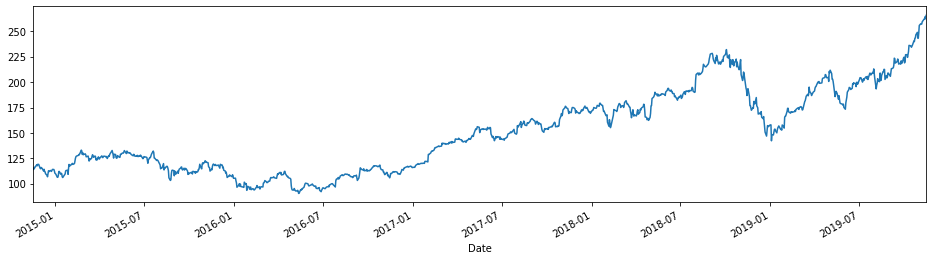

In [95]:
AAPL['Close'].plot(figsize=(16,4))

## Univariate Model

In [7]:
look_back = 60
univariate_seq = AAPL['Close']
train_percent = .8
n_train = int(train_percent * len(univariate_seq))
training_set = univariate_seq[:n_train]
training_set=pd.DataFrame(training_set)
testing_set = univariate_seq[n_train - look_back:]
testing_set=pd.DataFrame(testing_set)
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
X_train = []
y_train = []
for i in range(look_back, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-look_back:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [9]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

#Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.25))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.25))

# Adding the output layer
regressor.add(Dense(units = 1))

Training with: adam adagrad sgd
Train on 947 samples
Epoch 1/10
947/947 [==============================] - 8s 9ms/sample - loss: 0.0286
Epoch 2/10
947/947 [==============================] - 3s 3ms/sample - loss: 0.0064
Epoch 3/10
947/947 [==============================] - 3s 3ms/sample - loss: 0.0059
Epoch 4/10
947/947 [==============================] - 3s 3ms/sample - loss: 0.0065
Epoch 5/10
947/947 [==============================] - 3s 3ms/sample - loss: 0.0057
Epoch 6/10
947/947 [==============================] - 3s 3ms/sample - loss: 0.0049
Epoch 7/10
947/947 [==============================] - 3s 3ms/sample - loss: 0.0048
Epoch 8/10
947/947 [==============================] - 3s 3ms/sample - loss: 0.0054
Epoch 9/10
947/947 [==============================] - 3s 3ms/sample - loss: 0.0041
Epoch 10/10
947/947 [==============================] - 3s 3ms/sample - loss: 0.0041
Training with: adam adagrad sgd
Train on 947 samples
Epoch 1/10
947/947 [==============================] - 8s 8ms/sa

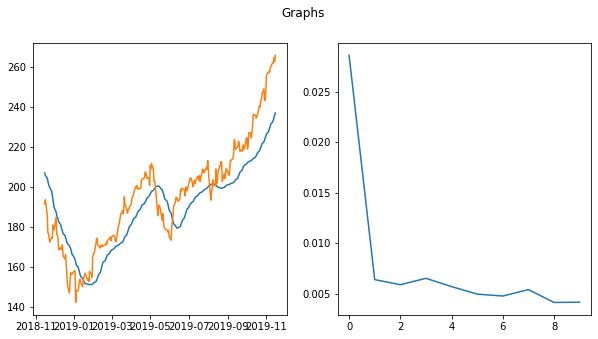

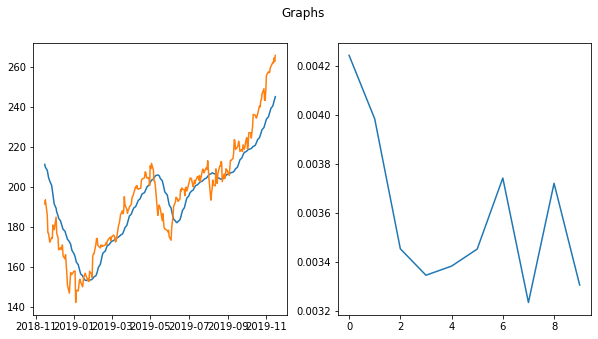

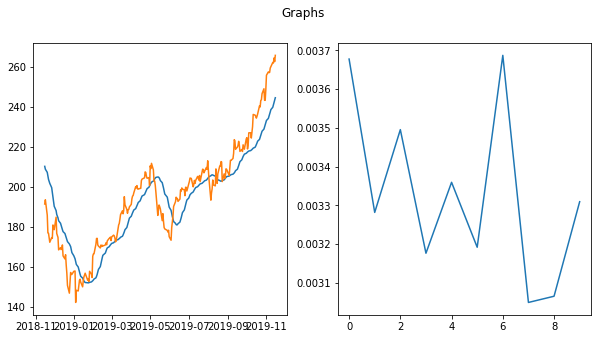

In [10]:
algorithms = ['adam', 'adagrad']
for i in algorithms:
    print(f'Training with: {" ".join(str(x) for x in algorithms)}')
    # Compiling the RNN
    regressor.compile(optimizer = i , loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    history=regressor.fit(X_train, y_train, epochs = 10, batch_size = 32)
    testing_set_scaled = sc.transform(testing_set.to_numpy().reshape(-1, 1))
    X_test = []
    for i in range(look_back, testing_set_scaled.shape[0]):
        X_test.append(testing_set_scaled[i-look_back:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    predicted_stock_price = pd.DataFrame(predicted_stock_price)
    predicted_stock_price.index = testing_set[look_back:].index

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(predicted_stock_price)
    plt.plot(testing_set[look_back:])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.suptitle('Graphs')

### Univariate Regularization

1. Applying regularizations to the input layer using kernel_regularizer


## L1 with different optimizers(SGD, Adam, Adagrad)

In [11]:
look_back_uni = 60
univariate_seq = AAPL['Close']
train_percent = .8
n_train = int(train_percent * len(univariate_seq))
training_set = univariate_seq[:n_train]
training_set=pd.DataFrame(training_set)
testing_set = univariate_seq[n_train - look_back:]
testing_set=pd.DataFrame(testing_set)
#trainging set = 1007, testing set = 312


sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []
y_train = []
for i in range(look_back, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-look_back:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from tensorflow.keras.regularizers import l1, l2, l1_l2
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, input_shape = (X_train.shape[1], 1), 
                   kernel_regularizer=l1(0.0001), recurrent_regularizer=l1(0.0001), bias_regularizer=l1(0.0001)))
regressor.add(Dropout(0.25))

# Adding the output layer
regressor.add(Dense(units = 1))

Train on 947 samples
Epoch 1/15
947/947 [==============================] - 2s 2ms/sample - loss: 0.1170
Epoch 2/15
947/947 [==============================] - 1s 574us/sample - loss: 0.0613
Epoch 3/15
947/947 [==============================] - 1s 571us/sample - loss: 0.0506
Epoch 4/15
947/947 [==============================] - 1s 570us/sample - loss: 0.0427
Epoch 5/15
947/947 [==============================] - 1s 573us/sample - loss: 0.0377
Epoch 6/15
947/947 [==============================] - 1s 569us/sample - loss: 0.0328
Epoch 7/15
947/947 [==============================] - 1s 575us/sample - loss: 0.0296
Epoch 8/15
947/947 [==============================] - 1s 573us/sample - loss: 0.0271
Epoch 9/15
947/947 [==============================] - 1s 550us/sample - loss: 0.0247
Epoch 10/15
947/947 [==============================] - 1s 562us/sample - loss: 0.0232
Epoch 11/15
947/947 [==============================] - 1s 568us/sample - loss: 0.0218
Epoch 12/15
947/947 [=======================

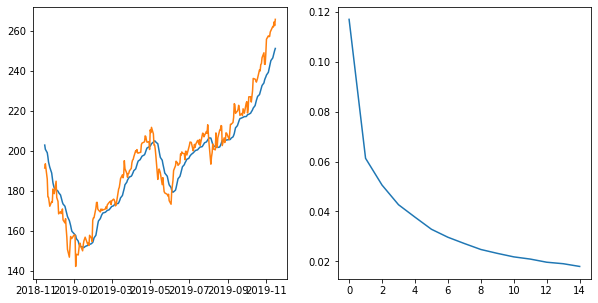

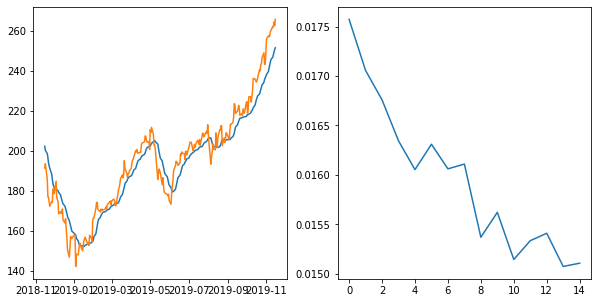

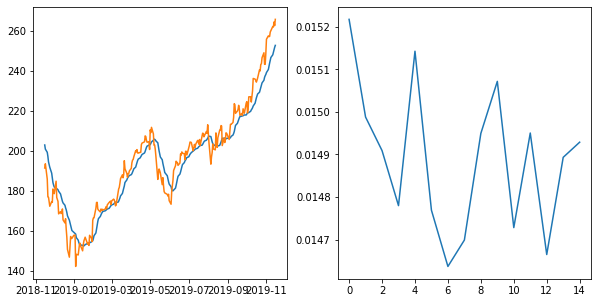

In [12]:
for i in algorithms:
    # Compiling the RNN
    regressor.compile(optimizer = i, loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    history = regressor.fit(X_train, y_train, epochs = 15, batch_size = 50)

    testing_set_scaled = sc.transform(testing_set.to_numpy().reshape(-1, 1))
    X_test = []
    for i in range(look_back, testing_set_scaled.shape[0]):
        X_test.append(testing_set_scaled[i-look_back:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    predicted_stock_price = pd.DataFrame(predicted_stock_price)
    predicted_stock_price.index = testing_set[look_back:].index

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(predicted_stock_price)
    plt.plot(testing_set[look_back:])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])



In [13]:
look_back_uni = 60
univariate_seq = AAPL['Close']
train_percent = .8
n_train = int(train_percent * len(univariate_seq))
training_set = univariate_seq[:n_train]
training_set=pd.DataFrame(training_set)
testing_set = univariate_seq[n_train - look_back:]
testing_set=pd.DataFrame(testing_set)
#trainging set = 1007, testing set = 312


sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []
y_train = []
for i in range(look_back, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-look_back:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from tensorflow.keras.regularizers import l1, l2, l1_l2
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 25, input_shape = (X_train.shape[1], 1), 
                   kernel_regularizer=l1(0.0001), recurrent_regularizer=l1(0.001), bias_regularizer=l1(0.001), return_sequences= True))


regressor.add(LSTM(units = 25,kernel_regularizer=l1(0.001), recurrent_regularizer=l1(0.001), bias_regularizer=l1(0.001), return_sequences= True))
regressor.add(Dropout (.2))

regressor.add(LSTM(units = 25))
regressor.add(Dropout(0.25))


# Adding the output layer
regressor.add(Dense(units = 1))

Train on 947 samples
Epoch 1/15
947/947 [==============================] - 5s 6ms/sample - loss: 0.7150
Epoch 2/15
947/947 [==============================] - 2s 2ms/sample - loss: 0.5821
Epoch 3/15
947/947 [==============================] - 2s 2ms/sample - loss: 0.4858
Epoch 4/15
947/947 [==============================] - 2s 2ms/sample - loss: 0.4034
Epoch 5/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.3338
Epoch 6/15
947/947 [==============================] - 1s 1ms/sample - loss: 0.2754
Epoch 7/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.2259
Epoch 8/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.1863
Epoch 9/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.1549
Epoch 10/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.1311
Epoch 11/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.1118
Epoch 12/15
947/947 [==============================] - 1s 1ms/sa

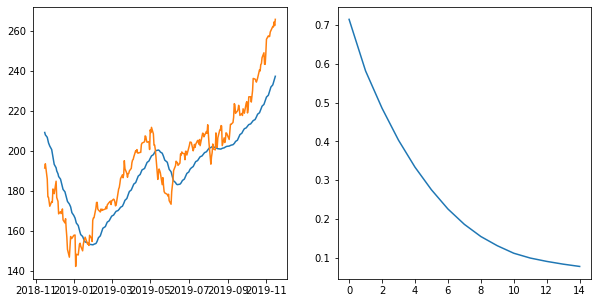

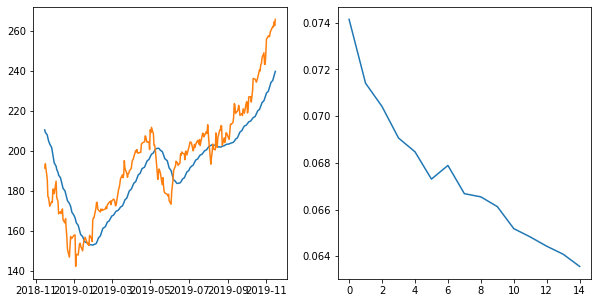

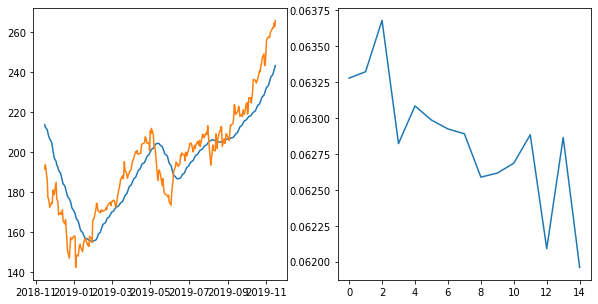

In [14]:
for i in algorithms:
    # Compiling the RNN
    regressor.compile(optimizer = i , loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    history = regressor.fit(X_train, y_train, epochs = 15, batch_size = 50)

    testing_set_scaled = sc.transform(testing_set.to_numpy().reshape(-1, 1))
    X_test = []
    for i in range(look_back, testing_set_scaled.shape[0]):
        X_test.append(testing_set_scaled[i-look_back:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    predicted_stock_price = pd.DataFrame(predicted_stock_price)
    predicted_stock_price.index = testing_set[look_back:].index

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(predicted_stock_price)
    plt.plot(testing_set[look_back:])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])

## L2 with different optimizers(SGD, Adam, Adagrad)

In [15]:
look_back_uni = 60
univariate_seq = AAPL['Close']
train_percent = .8
n_train = int(train_percent * len(univariate_seq))
training_set = univariate_seq[:n_train]
training_set=pd.DataFrame(training_set)
testing_set = univariate_seq[n_train - look_back:]
testing_set=pd.DataFrame(testing_set)
#trainging set = 1007, testing set = 312


sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []
y_train = []
for i in range(look_back, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-look_back:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from tensorflow.keras.regularizers import l1, l2, l1_l2
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 25, input_shape = (X_train.shape[1], 1), 
                   kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001)))

regressor.add(Dropout(0.3))

# Adding the output layer
regressor.add(Dense(units = 1))



Train on 947 samples
Epoch 1/15
947/947 [==============================] - 2s 2ms/sample - loss: 0.1605
Epoch 2/15
947/947 [==============================] - 1s 542us/sample - loss: 0.0708
Epoch 3/15
947/947 [==============================] - 1s 529us/sample - loss: 0.0575
Epoch 4/15
947/947 [==============================] - 1s 549us/sample - loss: 0.0507
Epoch 5/15
947/947 [==============================] - 1s 546us/sample - loss: 0.0475
Epoch 6/15
947/947 [==============================] - 1s 547us/sample - loss: 0.0449
Epoch 7/15
947/947 [==============================] - 1s 532us/sample - loss: 0.0417
Epoch 8/15
947/947 [==============================] - 1s 552us/sample - loss: 0.0389
Epoch 9/15
947/947 [==============================] - 1s 544us/sample - loss: 0.0373
Epoch 10/15
947/947 [==============================] - 0s 508us/sample - loss: 0.0363
Epoch 11/15
947/947 [==============================] - 1s 543us/sample - loss: 0.0345
Epoch 12/15
947/947 [=======================

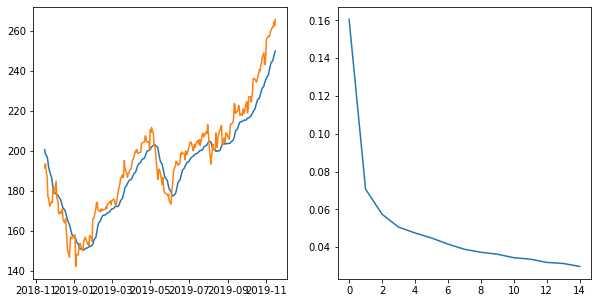

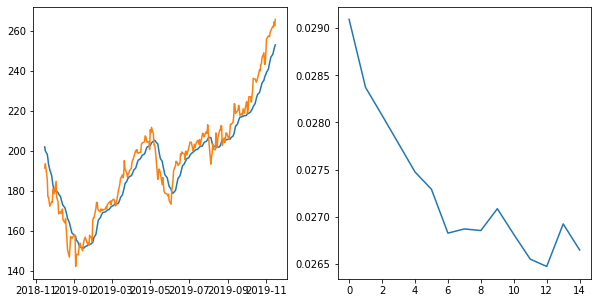

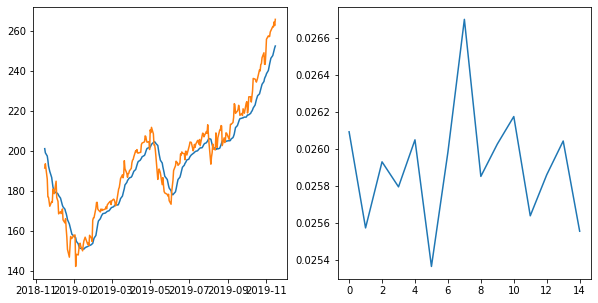

In [16]:
for i in algorithms:

    # Compiling the RNN
    regressor.compile(optimizer = i, loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    history = regressor.fit(X_train, y_train, epochs = 15, batch_size = 50)

    testing_set_scaled = sc.transform(testing_set.to_numpy().reshape(-1, 1))
    X_test = []
    for i in range(look_back, testing_set_scaled.shape[0]):
        X_test.append(testing_set_scaled[i-look_back:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    predicted_stock_price = pd.DataFrame(predicted_stock_price)
    predicted_stock_price.index = testing_set[look_back:].index

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(predicted_stock_price)
    plt.plot(testing_set[look_back:])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])

In [17]:
look_back_uni = 60
univariate_seq = AAPL['Close']
train_percent = .8
n_train = int(train_percent * len(univariate_seq))
training_set = univariate_seq[:n_train]
training_set=pd.DataFrame(training_set)
testing_set = univariate_seq[n_train - look_back:]
testing_set=pd.DataFrame(testing_set)
#trainging set = 1007, testing set = 312


sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []
y_train = []
for i in range(look_back, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-look_back:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from tensorflow.keras.regularizers import l1, l2, l1_l2
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 25, input_shape = (X_train.shape[1], 1), 
                   kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001), bias_regularizer=l2(0.001), return_sequences= True))

regressor.add(LSTM(units = 25, 
                   kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.0001), bias_regularizer=l2(0.001), return_sequences = True))
regressor.add(Dropout(0.1))


regressor.add(LSTM(units=25))
regressor.add(Dropout(.25))

# Adding the output layer
regressor.add(Dense(units = 1))


Train on 947 samples
Epoch 1/15
947/947 [==============================] - 5s 6ms/sample - loss: 0.1215
Epoch 2/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.0921
Epoch 3/15
947/947 [==============================] - 2s 2ms/sample - loss: 0.0849
Epoch 4/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.0775
Epoch 5/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.0722
Epoch 6/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.0669
Epoch 7/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.0628
Epoch 8/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.0590
Epoch 9/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.0558
Epoch 10/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.0543
Epoch 11/15
947/947 [==============================] - 1s 2ms/sample - loss: 0.0514
Epoch 12/15
947/947 [==============================] - 1s 2ms/sa

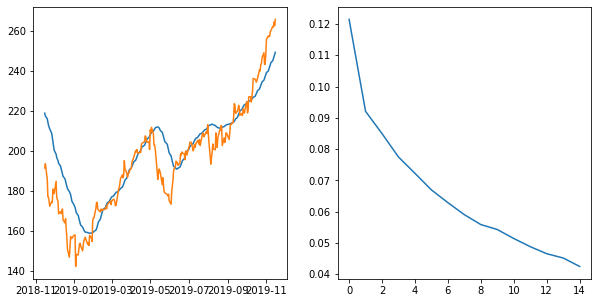

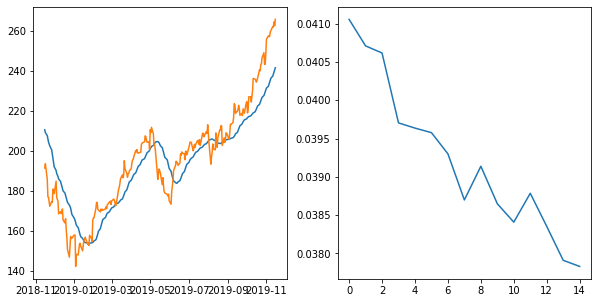

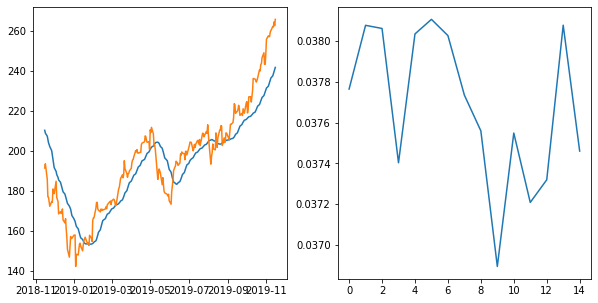

In [18]:
for i in algorithms:

    # Compiling the RNN
    regressor.compile(optimizer = i , loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    history = regressor.fit(X_train, y_train, epochs = 15, batch_size = 50)

    testing_set_scaled = sc.transform(testing_set.to_numpy().reshape(-1, 1))
    X_test = []
    for i in range(look_back, testing_set_scaled.shape[0]):
        X_test.append(testing_set_scaled[i-look_back:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    predicted_stock_price = pd.DataFrame(predicted_stock_price)
    predicted_stock_price.index = testing_set[look_back:].index

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(predicted_stock_price)
    plt.plot(testing_set[look_back:])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])

## L1 and L2 with different optimizers(SGD, Adam, Adagrad)

In [19]:
look_back_uni = 60
univariate_seq = AAPL['Close']
train_percent = .8
n_train = int(train_percent * len(univariate_seq))
training_set = univariate_seq[:n_train]
training_set=pd.DataFrame(training_set)
testing_set = univariate_seq[n_train - look_back:]
testing_set=pd.DataFrame(testing_set)
#trainging set = 1007, testing set = 312


sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []
y_train = []
for i in range(look_back, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-look_back:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from tensorflow.keras.regularizers import l1, l2, l1_l2
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 25, input_shape = (X_train.shape[1], 1), 
                   kernel_regularizer=l1_l2(l1 =0.001, l2 =0.001 ), recurrent_regularizer=l1_l2(l1= 0.001, l2 = .001), bias_regularizer=l1_l2(l1 = 0.01, l2 = 0.01)))
#regressor.add(Dropout(0.1))
# Adding the output layer
regressor.add(Dense(units = 1))



Train on 947 samples
Epoch 1/15
947/947 [==============================] - 2s 2ms/sample - loss: 0.7579
Epoch 2/15
947/947 [==============================] - 1s 532us/sample - loss: 0.6710
Epoch 3/15
947/947 [==============================] - 0s 521us/sample - loss: 0.6174
Epoch 4/15
947/947 [==============================] - 1s 549us/sample - loss: 0.5725
Epoch 5/15
947/947 [==============================] - 1s 554us/sample - loss: 0.5344
Epoch 6/15
947/947 [==============================] - 0s 479us/sample - loss: 0.5017
Epoch 7/15
947/947 [==============================] - 0s 525us/sample - loss: 0.4735
Epoch 8/15
947/947 [==============================] - 1s 552us/sample - loss: 0.4490
Epoch 9/15
947/947 [==============================] - 0s 518us/sample - loss: 0.4273
Epoch 10/15
947/947 [==============================] - 1s 531us/sample - loss: 0.4080
Epoch 11/15
947/947 [==============================] - 1s 545us/sample - loss: 0.3906
Epoch 12/15
947/947 [=======================

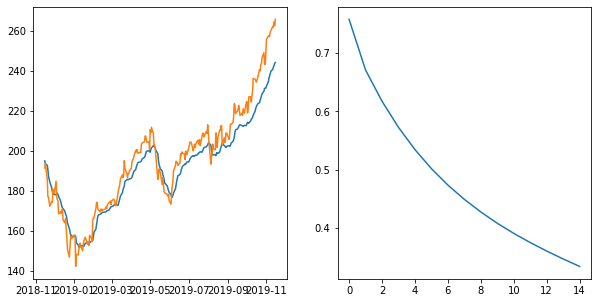

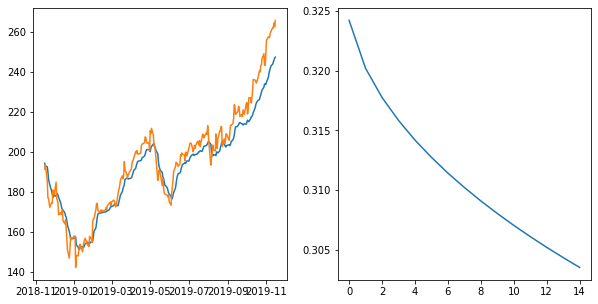

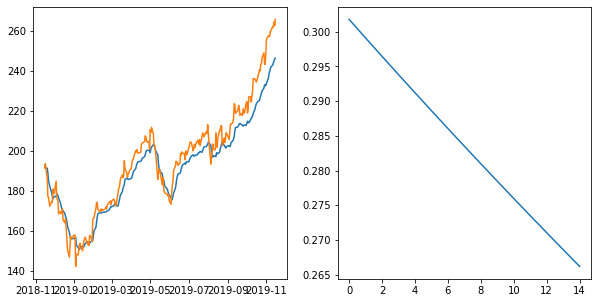

In [20]:
for i in algorithms:
    # Compiling the RNN
    regressor.compile(optimizer = i, loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    history = regressor.fit(X_train, y_train, epochs = 15, batch_size = 50)

    testing_set_scaled = sc.transform(testing_set.to_numpy().reshape(-1, 1))
    X_test = []
    for i in range(look_back, testing_set_scaled.shape[0]):
        X_test.append(testing_set_scaled[i-look_back:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    predicted_stock_price = pd.DataFrame(predicted_stock_price)
    predicted_stock_price.index = testing_set[look_back:].index

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(predicted_stock_price)
    plt.plot(testing_set[look_back:])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])

## Multivariate Model

In [ ]:
look_back_multi = 60

In [ ]:
multivariate_seq = MMM
train_percent = .8
n_train = int(train_percent * len(multivariate_seq))
training_set = multivariate_seq[:n_train]
training_set=pd.DataFrame(training_set)
testing_set = multivariate_seq[n_train - look_back:]
testing_set=pd.DataFrame(testing_set)

In [ ]:
# Feature Scaling
scMultiVariate = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scMultiVariate.fit_transform(training_set)

In [ ]:
X_train = []
y_train = []
for i in range(look_back_multi, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-look_back_multi:i, :])
    y_train.append(training_set_scaled[i, 1])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))

In [ ]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 6)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

In [ ]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 10, batch_size = 32)

In [ ]:
testing_set_scaled = scMultiVariate.transform(testing_set.to_numpy())
X_test = []
for i in range(look_back_multi, testing_set_scaled.shape[0]):
    X_test.append(testing_set_scaled[i-look_back_multi:i, :])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scMultiVariate.inverse_transform(np.repeat(predicted_stock_price, 6, axis=1))[:, 1]
predicted_stock_price = pd.DataFrame(predicted_stock_price)
Y_test = testing_set['Close'][look_back_multi:]

In [ ]:
predicted_stock_price.index = Y_test.index
plt.plot(predicted_stock_price)
plt.plot(Y_test)
plt.show()

## Multi-Series Univariate Model

In [141]:
look_back_uni_series = 60
close_columns = []
scUniSeries = MinMaxScaler(feature_range = (0, 1))
scUniSeries2 = MinMaxScaler(feature_range = (0, 1))
for ind in data.columns:
    if(('Close' in ind) & ('Adj Close' not in ind) & (('AAPL' in ind) | ('MSFT' in ind))):
        close_columns.append(ind)
univariate_seqs = scUniSeries.fit_transform(data[close_columns])
univariate_sols = scUniSeries2.fit_transform(data["Close AAPL"].to_numpy().reshape(-1, 1))
train_percent = .8
n_train = int(train_percent * len(univariate_seqs))
training_set = univariate_seqs[:n_train]
Y_train = univariate_sols[look_back_uni_series:n_train]
testing_set = univariate_seqs[n_train - look_back_uni_series:]
Y_test = univariate_sols[n_train:]
X_train = []
y_train = []
for i in range(look_back_uni_series, training_set.shape[0]):
    X_train.append(training_set[i-look_back_uni_series:i, :])
X_train = np.array(X_train)

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_90 (TimeDis (None, None, 60, 32)      96        
_________________________________________________________________
time_distributed_91 (TimeDis (None, None, 1920)        0         
_________________________________________________________________
dense_45 (Dense)             (None, None, 1)           1921      
Total params: 2,017
Trainable params: 2,017
Non-trainable params: 0
_________________________________________________________________
Train on 947 samples
Epoch 1/10
947/947 [==============================] - 0s 409us/sample - loss: 0.0087
Epoch 2/10
947/947 [==============================] - 0s 68us/sample - loss: 0.0015
Epoch 3/10
947/947 [==============================] - 0s 61us/sample - loss: 9.5103e-04
Epoch 4/10
947/947 [==============================] - 0s 72us/sample - loss: 9.4577e-04
Epoch 5/10
947/

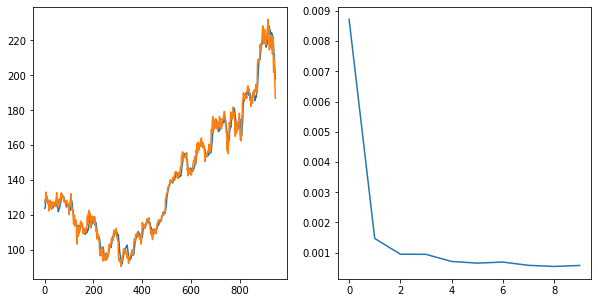

In [143]:
# Initialising the RNN
regressor = Sequential()

regressor.add(TimeDistributed(Conv1D(filters = 32, kernel_size=1), input_shape=(None, look_back_uni_series, 2)))
#regressor.add(TimeDistributed(MaxPooling1D(pool_size=2)))
regressor.add(TimeDistributed(Flatten()))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.summary()

# Fitting the RNN to the Training set
history = regressor.fit(X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]), Y_train, epochs = 10)
predicted_stock_price = regressor.predict(X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])).reshape(-1, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(scUniSeries2.inverse_transform(predicted_stock_price))
plt.plot(scUniSeries2.inverse_transform(Y_train))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])


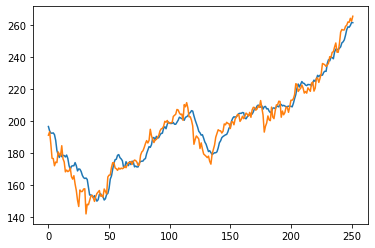

In [144]:
X_test = []
for i in range(look_back_uni_series, testing_set.shape[0]):
    X_test.append(testing_set[i-look_back_uni_series:i, :])

X_test = np.array(X_test)
# Use the following line for convNN
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
# predicted_stock_price = regressor.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])).reshape(-1, 1)
predicted_stock_price = regressor.predict(X_test).reshape(-1, 1)

#plotting the test data
plt.plot(scUniSeries2.inverse_transform(predicted_stock_price))
plt.plot(scUniSeries2.inverse_transform(Y_test))
plt.show()

 This model above was already overfitting because we do not have a lot of inputs so I reduced the complexity of the model to reduce overfitting.

## Univariate Model With GRU

In [54]:
look_back_uni_series = 60
close_columns = []
scUniSeries = MinMaxScaler(feature_range = (0, 1))
scUniSeries2 = MinMaxScaler(feature_range = (0, 1))
for ind in data.columns:
    if(('Close' in ind) & ('Adj Close' not in ind) & ('AAPL' in ind)):
        close_columns.append(ind)
univariate_seqs = scUniSeries.fit_transform(data[close_columns])
univariate_sols = scUniSeries2.fit_transform(data["Close AAPL"].to_numpy().reshape(-1, 1))
train_percent = .8
n_train = int(train_percent * len(univariate_seqs))
training_set = univariate_seqs[:n_train]
Y_train = univariate_sols[look_back_uni_series:n_train]
testing_set = univariate_seqs[n_train - look_back_uni_series:]
Y_test = univariate_sols[n_train:]


X_train = []
y_train = []
for i in range(look_back_uni_series, training_set.shape[0]):
    X_train.append(training_set[i-look_back_uni_series:i, :])
X_train = np.array(X_train)

Train on 947 samples
Epoch 1/10
947/947 [==============================] - 4s 4ms/sample - loss: 0.0431
Epoch 2/10
947/947 [==============================] - 2s 2ms/sample - loss: 0.0027
Epoch 3/10
947/947 [==============================] - 2s 2ms/sample - loss: 8.8712e-04
Epoch 4/10
947/947 [==============================] - 2s 2ms/sample - loss: 7.1524e-04
Epoch 5/10
947/947 [==============================] - 2s 2ms/sample - loss: 6.7587e-04
Epoch 6/10
947/947 [==============================] - 2s 2ms/sample - loss: 6.5593e-04
Epoch 7/10
947/947 [==============================] - 2s 2ms/sample - loss: 6.3079e-04
Epoch 8/10
947/947 [==============================] - 2s 2ms/sample - loss: 6.0527e-04
Epoch 9/10
947/947 [==============================] - 2s 2ms/sample - loss: 5.8216e-04
Epoch 10/10
947/947 [==============================] - 2s 2ms/sample - loss: 5.5529e-04


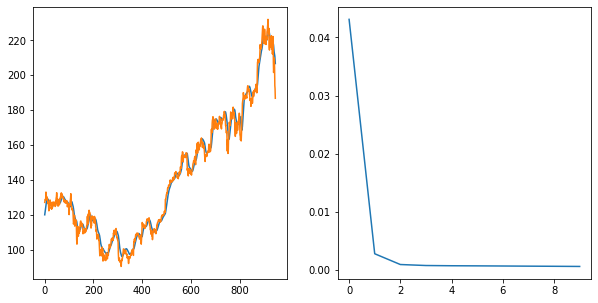

In [55]:
# Initialising the RNN
regressor = Sequential()
regressor.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(LSTM(10))
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = regressor.fit(X_train, Y_train, epochs = 10)
predicted_stock_price = regressor.predict(X_train).reshape(-1, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(scUniSeries2.inverse_transform(predicted_stock_price))
plt.plot(scUniSeries2.inverse_transform(Y_train))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])


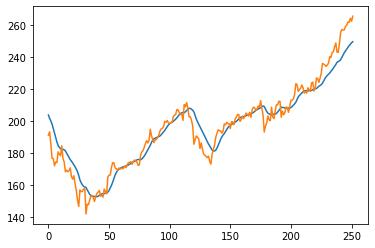

In [56]:
X_test = []
for i in range(look_back_uni_series, testing_set.shape[0]):
    X_test.append(testing_set[i-look_back_uni_series:i, :])

X_test = np.array(X_test)
# Use the following line for convNN
X_test = X_test
# predicted_stock_price = regressor.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])).reshape(-1, 1)
predicted_stock_price = regressor.predict(X_test).reshape(-1, 1)

#plotting test data
plt.plot(scUniSeries2.inverse_transform(predicted_stock_price))
plt.plot(scUniSeries2.inverse_transform(Y_test))
plt.show()

### GRU experimenting

In [157]:
look_back_uni_series = 60
close_columns = []
scUniSeries = MinMaxScaler(feature_range = (0, 1))
scUniSeries2 = MinMaxScaler(feature_range = (0, 1))
for ind in data.columns:
    if(('Close' in ind) & ('Adj Close' not in ind) & ('AAPL' in ind)):
        close_columns.append(ind)
univariate_seqs = scUniSeries.fit_transform(data[close_columns])
univariate_sols = scUniSeries2.fit_transform(data["Close AAPL"].to_numpy().reshape(-1, 1))
train_percent = .8
n_train = int(train_percent * len(univariate_seqs))
training_set = univariate_seqs[:n_train]
Y_train = univariate_sols[look_back_uni_series:n_train]
testing_set = univariate_seqs[n_train - look_back_uni_series:]
Y_test = univariate_sols[n_train:]


X_train = []
y_train = []
for i in range(look_back_uni_series, training_set.shape[0]):
    X_train.append(training_set[i-look_back_uni_series:i, :])
X_train = np.array(X_train)

Train on 947 samples
Epoch 1/20
947/947 [==============================] - 8s 8ms/sample - loss: 0.0247
Epoch 2/20
947/947 [==============================] - 6s 6ms/sample - loss: 0.0013
Epoch 3/20
947/947 [==============================] - 6s 6ms/sample - loss: 9.7985e-04
Epoch 4/20
947/947 [==============================] - 6s 6ms/sample - loss: 7.4537e-04
Epoch 5/20
947/947 [==============================] - 6s 6ms/sample - loss: 7.1692e-04
Epoch 6/20
947/947 [==============================] - 6s 6ms/sample - loss: 5.9435e-04
Epoch 7/20
947/947 [==============================] - 6s 6ms/sample - loss: 6.1527e-04
Epoch 8/20
947/947 [==============================] - 6s 6ms/sample - loss: 5.9696e-04
Epoch 9/20
947/947 [==============================] - 6s 6ms/sample - loss: 5.1806e-04
Epoch 10/20
947/947 [==============================] - 6s 6ms/sample - loss: 4.9118e-04
Epoch 11/20
947/947 [==============================] - 6s 6ms/sample - loss: 4.5756e-04
Epoch 12/20
947/947 [=======

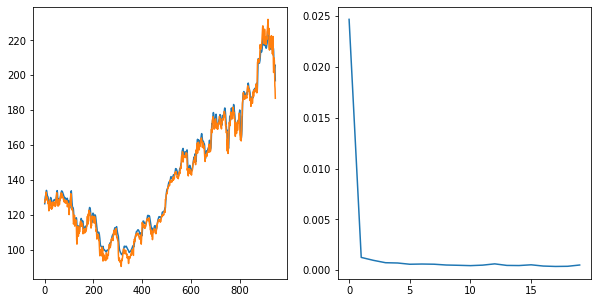

In [158]:
regressor = Sequential()
regressor.add(GRU(units=512,
              return_sequences=True,
              input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(GRU(units=256))
regressor.add(Dropout(0.2))
regressor.add(Dense(1, activation='sigmoid'))
regressor.compile(loss='mse', optimizer='adam')

# Fitting the RNN to the Training set
history = regressor.fit(X_train, Y_train, epochs = 20)
predicted_stock_price = regressor.predict(X_train).reshape(-1, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(scUniSeries2.inverse_transform(predicted_stock_price))
plt.plot(scUniSeries2.inverse_transform(Y_train))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])


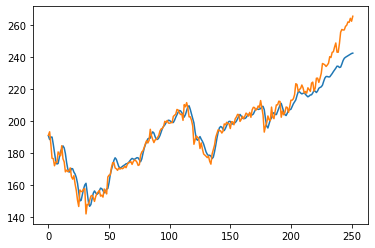

In [159]:
X_test = []
for i in range(look_back_uni_series, testing_set.shape[0]):
    X_test.append(testing_set[i-look_back_uni_series:i, :])

X_test = np.array(X_test)
# Use the following line for convNN
X_test = X_test
# predicted_stock_price = regressor.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])).reshape(-1, 1)
predicted_stock_price = regressor.predict(X_test).reshape(-1, 1)

#plotting test data
plt.plot(scUniSeries2.inverse_transform(predicted_stock_price))
plt.plot(scUniSeries2.inverse_transform(Y_test))
plt.show()

### Multi-series 2-D Univariate Model